What each column mean in this dataset?
* `Unnamed: 0`- unused original index column, can ignore
* `Residue`- amino acid residues
* `E6`, `E20`- Entropy values; 0 if always the same residue at a particular position. In E20, you consider all amino acids as different, while in E6, you consider similar amino acids (by chemical structure/properties) as indifferent so form groups (here, 6 groups.)
* `Protein` - PDB ID of protein from which the residue is derived
* `No.` - actual indice of residue in the chain
* `Res` - Residue
* `isUnstruct` - predicted values of disorder by isUnstruct model
* `E6.1`, `E20.1`, `E22` - can ignore
* `Vkbat` - measure of variability of secondary structure predicted by different secondary structure prediction models
* `chou_fasman`, `sspro_5`, `gor4`, `dsc`, `jnet`, `psipred` - all secondary structure prediction algorithms so these columns have values- helix, sheet or other for each residue position
* `homologues` - clusters of similar proteins (first set consisted of 6 proteins clustered together from PDB)
* `HAS_H`, `HAS_S`, `HAS_O`, `HAS_U` - 0 or 1 values like False or True; Helix (H), Sheet(S), Other(O) or Unordered(U); for first three rows (residues), there was no switch as all were always unordered
* `ProteinID` - PDB ID

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
from pandas import read_csv
import numpy as np
from sklearn.metrics import roc_curve, auc, roc_auc_score, precision_recall_curve,  accuracy_score
from sklearn.datasets import make_classification
import plotly.express as px
from sklearn.preprocessing import OneHotEncoder
import plotly.graph_objects as go
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [ ]:
from google.colab import files
files_uploaded = files.upload()

Saving bondugula_JDO_20230125_SLIM.csv to bondugula_JDO_20230125_SLIM.csv


In [ ]:
raw_data= pd.read_csv("bondugula_JDO_20230125_SLIM.csv")


In [ ]:
num=len(raw_data)
print (num)

1093286


In [ ]:
raw_data['Residue'].unique()

array(['D', 'T', 'H', 'K', 'V', 'F', 'N', 'R', 'I', 'M', 'L', 'G', 'Y',
       'S', 'E', 'A', 'P', 'Q', 'C', 'W', 'U', 'X'], dtype=object)

Create a column `is_switch` based on `HAS_H`, `HAS_S`, `HAS_O`, `HAS_U`.

Adding is_switch column

In [ ]:

raw_data['num_X'] = raw_data['HAS_H'] + raw_data['HAS_S'] + raw_data['HAS_O'] + raw_data['HAS_U']
raw_data['is_switch'] = np.where(raw_data['num_X'] > 1, 1, 0)
percent_switches = (raw_data['is_switch'].sum())/(len(raw_data['is_switch']))
print("Percentage of proteins in dataset that are switches is " + str(round(percent_switches*100,2)) + "%")

Percentage of proteins in dataset that are switches is 16.38%


Removing E6.1, E20.1, E22, ProteinID and Res columns

In [ ]:
data = raw_data.drop(['E6.1', 'E20.1','Res','E22', 'ProteinID'], axis=1)
data.columns

Index(['Unnamed: 0', 'Residue', 'E6', 'E20', 'Protein', 'No.', 'isUnstruct',
       'Vkbat', 'chou_fasman', 'sspro_5', 'gor4', 'dsc', 'jnet', 'psipred',
       '# homologues', 'HAS_H', 'HAS_S', 'HAS_O', 'HAS_U', 'num_X',
       'is_switch'],
      dtype='object')

Data Processing

In [ ]:
def normalize_column(quant_column):
    magnitude = np.sqrt((np.power(quant_column,2)).sum())
    return quant_column/magnitude

def standardize_column(quant_column):
    U = np.mean(quant_column)
    o = np.std(quant_column)
    return (quant_column - U)/o

def squarevalue (data,quant_column):
    squared_column=data[quant_column]**2
    return squared_column

def scaling (data,quant_column):
    min_val=data[quant_column].min()
    max_val=data[quant_column].max()
    scaled_column=(data[quant_column]-min_val)/((max_val)-(min_val))
    return scaled_column

In [ ]:
processed_data = data.copy()
processed_data['squared_E6']=squarevalue(data,'E6')
processed_data['squared_E20']=squarevalue(data,'E20')
processed_data['squared_isUnstruct']=squarevalue(data,'isUnstruct')
processed_data['squared_Vkbat']=squarevalue(data,'Vkbat')
processed_data['scaledE6']=scaling(data,'E6')
processed_data['scaledE20']=scaling(data,'E20')
processed_data['scaled_isUnstruct']=scaling(data,'isUnstruct')
processed_data['scaled_Vkbat']=scaling(data,'Vkbat')
#processed_data.head(20)

Converting Residue data to numeric

In [ ]:
processed_data['Res_numeric'] = processed_data['Residue'].apply(lambda x: ord(str(x)))
processed_data['squared_Res_numeric']=squarevalue(processed_data,'Res_numeric')
processed_data['scaled_Res_numeric']=scaling(processed_data,'Res_numeric')
#processed_data['Res_numeric'] = standardize_column(processed_data['Res_numeric'])

One Hot Encoder

In [ ]:
ohe= OneHotEncoder()
ohe_features_array = ohe.fit_transform(processed_data[['chou_fasman', 'sspro_5', 'gor4', 'dsc', 'jnet', 'psipred']]).toarray()
feature_labels = ohe.categories_

feature_labels = ohe.get_feature_names_out(['chou_fasman', 'sspro_5', 'gor4', 'dsc', 'jnet', 'psipred'])
print(feature_labels)

ohe_df = pd.DataFrame(ohe_features_array, columns = feature_labels)
#ohe_df.tail(10)

['chou_fasman_Helix' 'chou_fasman_Other' 'chou_fasman_Sheet'
 'sspro_5_Helix' 'sspro_5_Other' 'sspro_5_Sheet' 'gor4_Helix' 'gor4_Other'
 'gor4_Sheet' 'dsc_Helix' 'dsc_Other' 'dsc_Sheet' 'jnet_Helix'
 'jnet_Other' 'jnet_Sheet' 'psipred_Helix' 'psipred_Other' 'psipred_Sheet']


In [ ]:
processed_data = processed_data.reset_index()

In [ ]:
df_mo = pd.concat([processed_data, ohe_df],axis=1)
df_mo = df_mo.drop(columns=['index'])
df_mo=df_mo.drop(columns=['Unnamed: 0'])
#df_mo.head(20)


Checking if there are empty cells in each column

In [ ]:
empty_cell_count=df_mo.isnull().sum()
print("empty cell count in column:")
print(empty_cell_count)

empty cell count in column:
Residue                   0
E6                     3710
E20                    3710
Protein                   0
No.                       0
isUnstruct                0
Vkbat                     0
chou_fasman               0
sspro_5                   0
gor4                      0
dsc                       0
jnet                      0
psipred                   0
# homologues              0
HAS_H                     0
HAS_S                     0
HAS_O                     0
HAS_U                     0
num_X                     0
is_switch                 0
squared_E6             3710
squared_E20            3710
squared_isUnstruct        0
squared_Vkbat             0
scaledE6               3710
scaledE20              3710
scaled_isUnstruct         0
scaled_Vkbat              0
Res_numeric               0
squared_Res_numeric       0
scaled_Res_numeric        0
chou_fasman_Helix         0
chou_fasman_Other         0
chou_fasman_Sheet         0
sspro_5_Helix       

Only if E6 and E20 Values will be used to fit the regression, run below codes

In [ ]:
df_mo=df_mo.dropna()  #regression doesn't work with empty cells. Have to remove.

In [ ]:
df_mo.columns

Index(['Residue', 'E6', 'E20', 'Protein', 'No.', 'isUnstruct', 'Vkbat',
       'chou_fasman', 'sspro_5', 'gor4', 'dsc', 'jnet', 'psipred',
       '# homologues', 'HAS_H', 'HAS_S', 'HAS_O', 'HAS_U', 'num_X',
       'is_switch', 'squared_E6', 'squared_E20', 'squared_isUnstruct',
       'squared_Vkbat', 'scaledE6', 'scaledE20', 'scaled_isUnstruct',
       'scaled_Vkbat', 'Res_numeric', 'squared_Res_numeric',
       'scaled_Res_numeric', 'chou_fasman_Helix', 'chou_fasman_Other',
       'chou_fasman_Sheet', 'sspro_5_Helix', 'sspro_5_Other', 'sspro_5_Sheet',
       'gor4_Helix', 'gor4_Other', 'gor4_Sheet', 'dsc_Helix', 'dsc_Other',
       'dsc_Sheet', 'jnet_Helix', 'jnet_Other', 'jnet_Sheet', 'psipred_Helix',
       'psipred_Other', 'psipred_Sheet'],
      dtype='object')

Model

Inclusion of 'HAS_H','HAS_S','HAS_O','HAS_U' will give the score 1.0 since they are the true values.

In [ ]:
simple_quant_features = ['E20','E6','isUnstruct','Vkbat', 'HAS_H','HAS_S','HAS_O','HAS_U']

target = "is_switch"

In [ ]:
train_data, test_data = train_test_split(df_mo, test_size=0.25, random_state=1)
X_train = train_data[simple_quant_features]
y_train = train_data[target]
X_test = test_data[simple_quant_features]
y_test = test_data[target]

Fitting with true data

In [ ]:
true_logistic_model = LogisticRegression().fit(train_data[simple_quant_features], y_train)

In [ ]:
preds = true_logistic_model.predict(X_test)
prob_preds = true_logistic_model.predict_proba(X_test)

In [ ]:
[print(f"{feat}: {coef:.4f}") for feat, coef in zip(simple_quant_features, true_logistic_model.coef_[0])];
print(f"Intercept: {true_logistic_model.intercept_[0]}")
print(f"Error: {(preds - y_test).sum()}")
print(f"Score: {true_logistic_model.score(X_test, y_test)}")

E20: 0.0195
E6: -0.0474
isUnstruct: 0.1379
Vkbat: 0.0464
HAS_H: 16.1408
HAS_S: 16.0410
HAS_O: 17.0821
HAS_U: 16.9777
Intercept: -25.95256054396731
Error: 0
Score: 1.0


WITH Processed Data

In [ ]:
df_mo.columns

Index(['level_0', 'Residue', 'E6', 'E20', 'Protein', 'No.', 'isUnstruct',
       'Vkbat', 'chou_fasman', 'sspro_5', 'gor4', 'dsc', 'jnet', 'psipred',
       '# homologues', 'HAS_H', 'HAS_S', 'HAS_O', 'HAS_U', 'num_X',
       'is_switch', 'squared_E6', 'squared_E20', 'squared_isUnstruct',
       'squared_Vkbat', 'scaledE6', 'scaledE20', 'scaled_isUnstruct',
       'scaled_Vkbat', 'Res_numeric', 'squared_Res_numeric',
       'scaled_Res_numeric', 'chou_fasman_Helix', 'chou_fasman_Other',
       'chou_fasman_Sheet', 'sspro_5_Helix', 'sspro_5_Other', 'sspro_5_Sheet',
       'gor4_Helix', 'gor4_Other', 'gor4_Sheet', 'dsc_Helix', 'dsc_Other',
       'dsc_Sheet', 'jnet_Helix', 'jnet_Other', 'jnet_Sheet', 'psipred_Helix',
       'psipred_Other', 'psipred_Sheet'],
      dtype='object')

In [ ]:
feature_sets = [
  ['squared_E20','HAS_H','HAS_S','HAS_U','HAS_O'],
  ['E6','isUnstruct','Vkbat'],
  ['E6','isUnstruct'],
  ['E6','Res_numeric','isUnstruct','Vkbat'],
  ['E6','Res_numeric','isUnstruct'],
  ['E6','Res_numeric','Vkbat'],
  ['E6','Res_numeric'],
  ['E6','Vkbat'],
  ['E6'],
  ['E20','isUnstruct','Vkbat'],
  ['E20','isUnstruct'],
  ['E20','Res_numeric','isUnstruct','Vkbat'],
  ['E20','Res_numeric','isUnstruct'],
  ['E20','Res_numeric','Vkbat'],
  ['E20','Res_numeric'],
  ['E20','Vkbat'],
  ['E20'],
  ['isUnstruct','Res_numeric'],
  ['isUnstruct','Vkbat'],
  ['isUnstruct'],
  ['Res_numeric','isUnstruct','Vkbat'],
  ['Res_numeric'],
  ['Vkbat','Res_numeric'],
  ['Vkbat'],
  ['squared_E6','scaledE6','squared_E20','scaledE20'],
  ['squared_E6', 'scaledE6'],
  ['squared_E20','scaledE20'],
  ['squared_E6','squared_Vkbat'],
  ['squared_E20','squared_Vkbat'],
  ['scaled_Vkbat'],
  ['scaled_isUnstruct'],
  ['squared_isUnstruct','scaled_isUnstruct'],
  ['chou_fasman_Helix','chou_fasman_Other','chou_fasman_Sheet'],
  ['sspro_5_Helix','sspro_5_Other', 'sspro_5_Sheet'],
  ['gor4_Helix','gor4_Other', 'gor4_Sheet'],
  ['dsc_Helix','dsc_Other','dsc_Sheet'],
  ['jnet_Helix', 'jnet_Other', 'jnet_Sheet'],
  [ 'psipred_Helix','psipred_Other', 'psipred_Sheet'],
  [ 'chou_fasman_Helix', 'chou_fasman_Other','chou_fasman_Sheet', 'sspro_5_Helix', 'sspro_5_Other', 'sspro_5_Sheet','gor4_Helix', 'gor4_Other', 'gor4_Sheet', 'dsc_Helix', 'dsc_Other','dsc_Sheet', 'jnet_Helix', 'jnet_Other', 'jnet_Sheet', 'psipred_Helix','psipred_Other', 'psipred_Sheet']

 ]


In [ ]:
logistic_models = []
roc_curves_logreg = []
prob_scores_logreg = []

for i, features in enumerate(feature_sets):
    print(f'{features=}')

    # Fit Logistic Regression model
    logistic_model = LogisticRegression().fit(train_data[features], train_data[target])

    # Print coefficients and intercept
    [print(f"{feature}: {coefficient:.4f}") for feature, coefficient in zip(features, logistic_model.coef_[0])]
    print(f"Intercept: {logistic_model.intercept_[0]:.4f}")

    score = logistic_model.score(test_data[features], test_data[target])
    print(f"Score: {score:.6f}")
    print('')

    logmodel_prob_scores = logistic_model.predict_proba(test_data[features])[:, 1]
    prob_scores_logreg.append((logmodel_prob_scores, f"Logistic Regression {i}"))

    AUC = {"AUC": "{:.3f}".format(roc_auc_score(test_data[target], logmodel_prob_scores))}
    print("AUC for our sample data is {:.3f}".format(float(AUC["AUC"])))
    print("=" * 300)
    print('')

features=['squared_E20', 'HAS_H', 'HAS_S', 'HAS_U', 'HAS_O']
squared_E20: -0.0018
HAS_H: 16.1467
HAS_S: 16.0489
HAS_U: 16.9864
HAS_O: 17.0836
Intercept: -25.8001
Score: 1.000000

AUC for our sample data is 1.000

features=['E6', 'isUnstruct', 'Vkbat']
E6: 0.0233
isUnstruct: 0.8075
Vkbat: 0.0729
Intercept: -2.0453
Score: 0.837015

AUC for our sample data is 0.564

features=['E6', 'isUnstruct']
E6: 0.0227
isUnstruct: 0.7545
Intercept: -1.8272
Score: 0.837015

AUC for our sample data is 0.554

features=['E6', 'Res_numeric', 'isUnstruct', 'Vkbat']
E6: 0.0225
Res_numeric: -0.0015
isUnstruct: 0.8074
Vkbat: 0.0731
Intercept: -1.9298
Score: 0.837015

AUC for our sample data is 0.564

features=['E6', 'Res_numeric', 'isUnstruct']
E6: 0.0223
Res_numeric: -0.0008
isUnstruct: 0.7543
Intercept: -1.7630
Score: 0.837015

AUC for our sample data is 0.554

features=['E6', 'Res_numeric', 'Vkbat']
E6: 0.0454
Res_numeric: -0.0016
Vkbat: 0.0609
Intercept: -1.6964
Score: 0.837015

AUC for our sample data is 

In [ ]:
# Checking count in test data for is_switch
sum(test_data[target]  == 0) / len(test_data[target])

0.8370154996071867

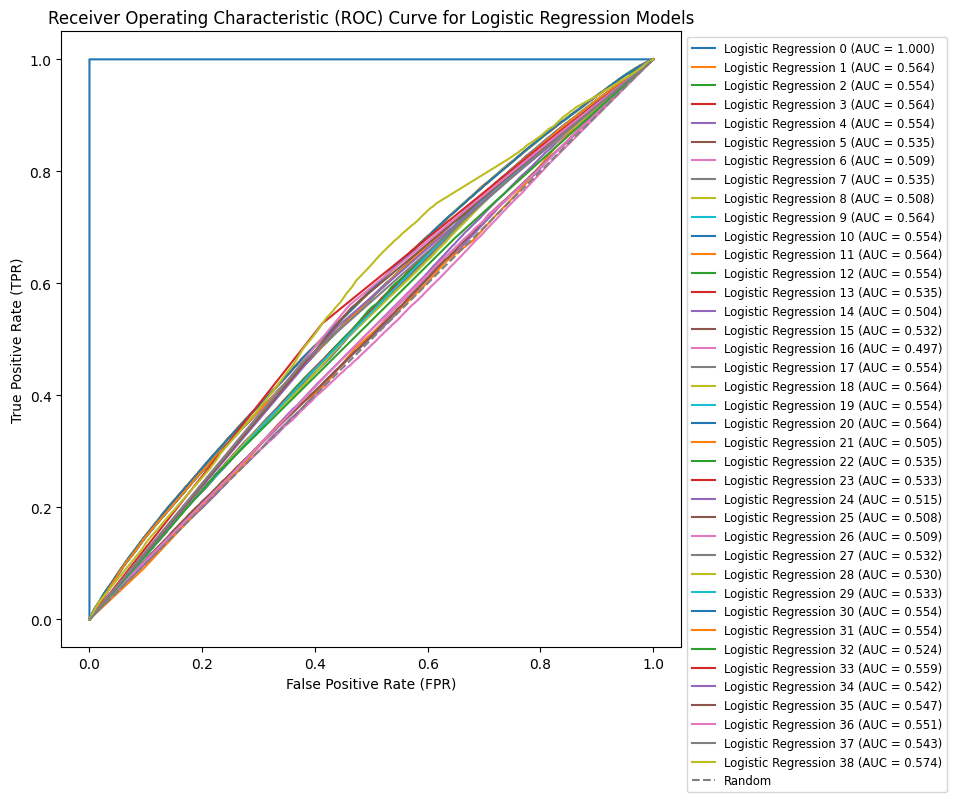

In [ ]:


plt.figure(figsize=(8, 8))

roc_curves_logreg = []

# Assuming prob_scores is a list of tuples (logmodel_prob_scores, label)
for (logmodel_prob_scores, label) in prob_scores_logreg:
    fpr, tpr, _ = roc_curve(test_data[target], logmodel_prob_scores)
    roc_auc = roc_auc_score(test_data[target], logmodel_prob_scores)
    roc_curves.append((fpr, tpr, label, roc_auc))
    plt.plot(fpr, tpr, label=f"{label} (AUC = {roc_auc:.3f})")

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')

# Set the legend font size using the fontsize parameter
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize='small')

plt.title('Receiver Operating Characteristic (ROC) Curve for Logistic Regression Models')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')

plt.show()

SVM Model

In [ ]:
svm_models = []
roc_curves_svm = []
prob_scores_svm = []

for i, features in enumerate(feature_sets):
    print(f'{features=}')

    svm_model = LinearSVC().fit(train_data[features], train_data[target])

    score = svm_model.score(test_data[features], test_data[target])
    print(f"Score: {score:.6f}")
    print('')

    auc_svm = np.round(roc_auc_score(test_data[target], svm_model.decision_function(test_data[features])), 3)
    print("AUC for our sample data is {}".format(auc_svm))
    print("=" * 300)
    print('')


    svm_decision_function = svm_model.decision_function(test_data[features])
    prob_scores_svm.append((svm_decision_function, f"Linear SVM {i}"))

features=['squared_E20', 'HAS_H', 'HAS_S', 'HAS_U', 'HAS_O']


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Score: 1.000000

AUC for our sample data is 1.0

features=['E6', 'isUnstruct', 'Vkbat']


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Score: 0.837015

AUC for our sample data is 0.564

features=['E6', 'isUnstruct']
Score: 0.837015

AUC for our sample data is 0.554

features=['E6', 'Res_numeric', 'isUnstruct', 'Vkbat']


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Score: 0.837015

AUC for our sample data is 0.56

features=['E6', 'Res_numeric', 'isUnstruct']


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Score: 0.837015

AUC for our sample data is 0.546

features=['E6', 'Res_numeric', 'Vkbat']


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Score: 0.837015

AUC for our sample data is 0.518

features=['E6', 'Res_numeric']


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Score: 0.162985

AUC for our sample data is 0.496

features=['E6', 'Vkbat']


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Score: 0.837015

AUC for our sample data is 0.535

features=['E6']
Score: 0.837015

AUC for our sample data is 0.508

features=['E20', 'isUnstruct', 'Vkbat']


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Score: 0.837015

AUC for our sample data is 0.564

features=['E20', 'isUnstruct']
Score: 0.837015

AUC for our sample data is 0.554

features=['E20', 'Res_numeric', 'isUnstruct', 'Vkbat']


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Score: 0.837015

AUC for our sample data is 0.558

features=['E20', 'Res_numeric', 'isUnstruct']


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Score: 0.837015

AUC for our sample data is 0.543

features=['E20', 'Res_numeric', 'Vkbat']


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Score: 0.162985

AUC for our sample data is 0.5

features=['E20', 'Res_numeric']


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Score: 0.837015

AUC for our sample data is 0.504

features=['E20', 'Vkbat']


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Score: 0.837015

AUC for our sample data is 0.532

features=['E20']
Score: 0.837015

AUC for our sample data is 0.497

features=['isUnstruct', 'Res_numeric']


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Score: 0.837015

AUC for our sample data is 0.547

features=['isUnstruct', 'Vkbat']


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Score: 0.837015

AUC for our sample data is 0.564

features=['isUnstruct']
Score: 0.837015

AUC for our sample data is 0.554

features=['Res_numeric', 'isUnstruct', 'Vkbat']


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Score: 0.837015

AUC for our sample data is 0.552

features=['Res_numeric']


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Score: 0.837015

AUC for our sample data is 0.505

features=['Vkbat', 'Res_numeric']


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Score: 0.162985

AUC for our sample data is 0.503

features=['Vkbat']


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Score: 0.837015

AUC for our sample data is 0.533

features=['squared_E6', 'scaledE6', 'squared_E20', 'scaledE20']


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Score: 0.837015

AUC for our sample data is 0.515

features=['squared_E6', 'scaledE6']
Score: 0.837015

AUC for our sample data is 0.508

features=['squared_E20', 'scaledE20']


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Score: 0.837015

AUC for our sample data is 0.51

features=['squared_E6', 'squared_Vkbat']


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Score: 0.837015

AUC for our sample data is 0.484

features=['squared_E20', 'squared_Vkbat']


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Score: 0.837015

AUC for our sample data is 0.527

features=['scaled_Vkbat']
Score: 0.837015

AUC for our sample data is 0.533

features=['scaled_isUnstruct']
Score: 0.837015

AUC for our sample data is 0.554

features=['squared_isUnstruct', 'scaled_isUnstruct']
Score: 0.837015

AUC for our sample data is 0.554

features=['chou_fasman_Helix', 'chou_fasman_Other', 'chou_fasman_Sheet']
Score: 0.837015

AUC for our sample data is 0.524

features=['sspro_5_Helix', 'sspro_5_Other', 'sspro_5_Sheet']
Score: 0.837015

AUC for our sample data is 0.559

features=['gor4_Helix', 'gor4_Other', 'gor4_Sheet']
Score: 0.837015

AUC for our sample data is 0.542

features=['dsc_Helix', 'dsc_Other', 'dsc_Sheet']
Score: 0.837015

AUC for our sample data is 0.547

features=['jnet_Helix', 'jnet_Other', 'jnet_Sheet']
Score: 0.837015

AUC for our sample data is 0.551

features=['psipred_Helix', 'psipred_Other', 'psipred_Sheet']
Score: 0.837015

AUC for our sample data is 0.543

features=['chou_fasman_Helix', '

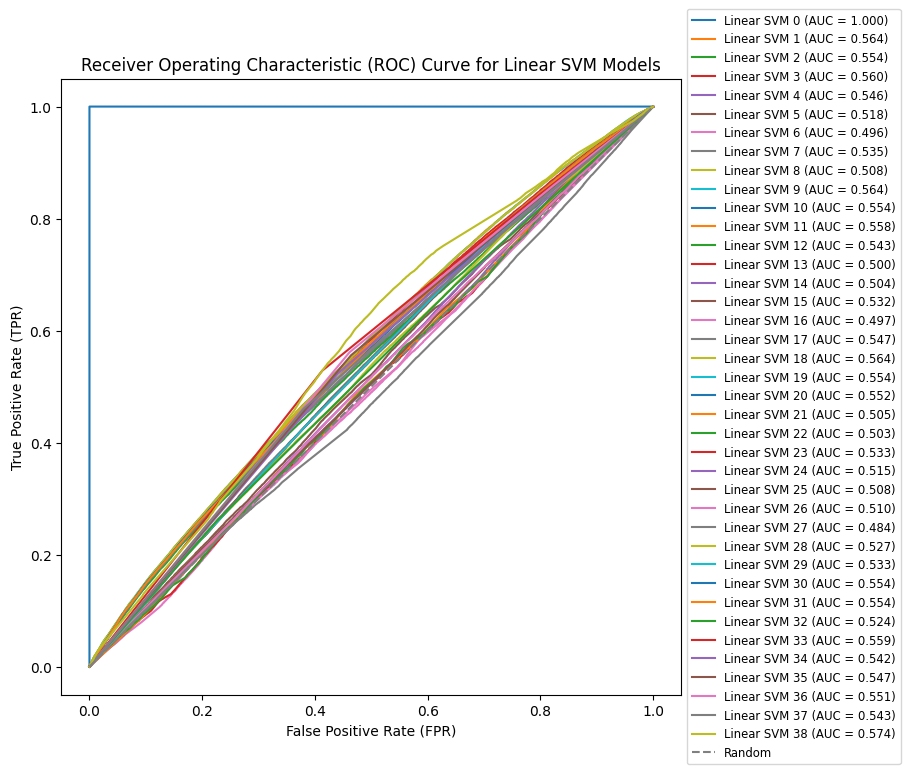

In [ ]:
plt.figure(figsize=(8, 8))

roc_curves_svm = []


for i, (prob_scores, label) in enumerate(prob_scores_svm):

    auc_svm = roc_auc_score(test_data[target], prob_scores)

    fpr, tpr, _ = roc_curve(test_data[target], prob_scores)
    roc_curves_svm.append((fpr, tpr, label, auc_svm))

for fpr, tpr, label, auc_svm in roc_curves_svm:
    plt.plot(fpr, tpr, label=f"{label} (AUC = {auc_svm:.3f})")

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.title('Receiver Operating Characteristic (ROC) Curve for Linear SVM Models')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize='small')
plt.show()

Random Forest

In [ ]:
rf_model = RandomForestClassifier(n_estimators = 25, oob_score = True)
rf_model.fit(train_data[simple_quant_features], train_data[target])
rf_model.get_params()

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 25,
 'n_jobs': None,
 'oob_score': True,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [ ]:
print(f"Out of bag estimate score: {rf_model.oob_score_}")
print(f"Train Score: {rf_model.score(train_data[simple_quant_features], train_data[target])}")
print(f"Test Score: {rf_model.score(test_data[simple_quant_features], test_data[target])}")

Out of bag estimate score: 0.9999975525647897
Train Score: 1.0
Test Score: 1.0


In [ ]:
rf_models = []
roc_curves_rf=[]
prob_scores_rf=[]

for i, features in enumerate(feature_sets):
    print(f'{features=}')


    rf_model = RandomForestClassifier(n_estimators = 25, oob_score = True)
    rf_model.fit(train_data[features], train_data[target])

    print(f"Out of bag estimate score: {rf_model.oob_score_}")
    print(f"Train Score: {rf_model.score(train_data[features], train_data[target])}")
    print(f"Test Score: {rf_model.score(test_data[features], test_data[target])}")

    rf_model_scores = rf_model.predict_proba(test_data[features])[:,1] # extracts probabilities of class 1 (being a switch)
    fpr_reg, tpr_reg, thresholds_reg = roc_curve(test_data[target], rf_model_scores)
    prob_scores_rf.append((rf_model_scores, f"Random Forest {i}"))

features=['squared_E20', 'HAS_H', 'HAS_S', 'HAS_U', 'HAS_O']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Out of bag estimate score: 0.9999963288471846
Train Score: 1.0
Test Score: 1.0
features=['E6', 'isUnstruct', 'Vkbat']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Out of bag estimate score: 0.7909168337041198
Train Score: 0.9924961636453079
Test Score: 0.7927634235702695
features=['E6', 'isUnstruct']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Out of bag estimate score: 0.7900161775467399
Train Score: 0.9893034844135089
Test Score: 0.7921393275916503
features=['E6', 'Res_numeric', 'isUnstruct', 'Vkbat']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Out of bag estimate score: 0.7992687063591709
Train Score: 0.9941518535650565
Test Score: 0.8026975630887612
features=['E6', 'Res_numeric', 'isUnstruct']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Out of bag estimate score: 0.7916094578686266
Train Score: 0.9931165884711117
Test Score: 0.7939381924711998
features=['E6', 'Res_numeric', 'Vkbat']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Out of bag estimate score: 0.7895046635877931
Train Score: 0.9178175730742968
Test Score: 0.7863425772961226
features=['E6', 'Res_numeric']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Out of bag estimate score: 0.7932651477883752
Train Score: 0.9090190434933711
Test Score: 0.7912949624441067
features=['E6', 'Vkbat']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Out of bag estimate score: 0.796356258458948
Train Score: 0.9030240509458113
Test Score: 0.7938684405677071
features=['E6']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Out of bag estimate score: 0.8008424071993754
Train Score: 0.8935781747517689
Test Score: 0.7995954389597422
features=['E20', 'isUnstruct', 'Vkbat']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Out of bag estimate score: 0.7967723224446941
Train Score: 0.9934555582477342
Test Score: 0.8004765156354399
features=['E20', 'isUnstruct']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Out of bag estimate score: 0.7962094123463317
Train Score: 0.9921143637525056
Test Score: 0.8003627098981623
features=['E20', 'Res_numeric', 'isUnstruct', 'Vkbat']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Out of bag estimate score: 0.8051058393356681
Train Score: 0.9946046290789567
Test Score: 0.810054553330837
features=['E20', 'Res_numeric', 'isUnstruct']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Out of bag estimate score: 0.798033975295589
Train Score: 0.9937088677919974
Test Score: 0.8012107461985213
features=['E20', 'Res_numeric', 'Vkbat']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Out of bag estimate score: 0.7803855199943219
Train Score: 0.9349386060877504
Test Score: 0.776959110699942
features=['E20', 'Res_numeric']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Out of bag estimate score: 0.7833554826219863
Train Score: 0.9273882684640631
Test Score: 0.7787726601907531
features=['E20', 'Vkbat']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Out of bag estimate score: 0.7860329767420232
Train Score: 0.9219255930747373
Test Score: 0.7832918493065192
features=['E20']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Out of bag estimate score: 0.7902535787621362
Train Score: 0.912660827086255
Test Score: 0.7864600541862156
features=['isUnstruct', 'Res_numeric']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Out of bag estimate score: 0.7539825889459141
Train Score: 0.987626991294473
Test Score: 0.746334353913816
features=['isUnstruct', 'Vkbat']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Out of bag estimate score: 0.7549468784187611
Train Score: 0.9817690551186884
Test Score: 0.748544387908691
features=['isUnstruct']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Out of bag estimate score: 0.7551683713052906
Train Score: 0.9560318264474744
Test Score: 0.7519989427079892
features=['Res_numeric', 'isUnstruct', 'Vkbat']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Out of bag estimate score: 0.7558561005993769
Train Score: 0.9899104483456562
Test Score: 0.7487352878550922
features=['Res_numeric']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Out of bag estimate score: 0.835865205058359
Train Score: 0.8358664287759642
Test Score: 0.8370154996071867
features=['Vkbat', 'Res_numeric']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Out of bag estimate score: 0.8358664287759642
Train Score: 0.8358676524935693
Test Score: 0.8370154996071867
features=['Vkbat']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Out of bag estimate score: 0.8358664287759642
Train Score: 0.8358664287759642
Test Score: 0.8370154996071867
features=['squared_E6', 'scaledE6', 'squared_E20', 'scaledE20']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Out of bag estimate score: 0.8142776027861602
Train Score: 0.9246532596165848
Test Score: 0.8175583896855291
features=['squared_E6', 'scaledE6']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Out of bag estimate score: 0.8009133828204733
Train Score: 0.8942891546803527
Test Score: 0.7998083658230357
features=['squared_E20', 'scaledE20']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Out of bag estimate score: 0.7902327755628489
Train Score: 0.9133485563803412
Test Score: 0.786401315741169
features=['squared_E6', 'squared_Vkbat']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Out of bag estimate score: 0.7965471584053491
Train Score: 0.9029873394176573
Test Score: 0.7940997231950777
features=['squared_E20', 'squared_Vkbat']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Out of bag estimate score: 0.7861259792800135
Train Score: 0.9219292642275527
Test Score: 0.7832404531671036
features=['scaled_Vkbat']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Out of bag estimate score: 0.8358664287759642
Train Score: 0.8358664287759642
Test Score: 0.8370154996071867
features=['scaled_isUnstruct']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Out of bag estimate score: 0.7551683713052906
Train Score: 0.9562043706297985
Test Score: 0.7511178660322915
features=['squared_isUnstruct', 'scaled_isUnstruct']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Out of bag estimate score: 0.7679929318071127
Train Score: 0.941320293398533
Test Score: 0.7657620946129503
features=['chou_fasman_Helix', 'chou_fasman_Other', 'chou_fasman_Sheet']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Out of bag estimate score: 0.8358664287759642
Train Score: 0.8358664287759642
Test Score: 0.8370154996071867
features=['sspro_5_Helix', 'sspro_5_Other', 'sspro_5_Sheet']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Out of bag estimate score: 0.8358664287759642
Train Score: 0.8358664287759642
Test Score: 0.8370154996071867
features=['gor4_Helix', 'gor4_Other', 'gor4_Sheet']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Out of bag estimate score: 0.8358664287759642
Train Score: 0.8358664287759642
Test Score: 0.8370154996071867
features=['dsc_Helix', 'dsc_Other', 'dsc_Sheet']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Out of bag estimate score: 0.8358664287759642
Train Score: 0.8358664287759642
Test Score: 0.8370154996071867
features=['jnet_Helix', 'jnet_Other', 'jnet_Sheet']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Out of bag estimate score: 0.8358664287759642
Train Score: 0.8358664287759642
Test Score: 0.8370154996071867
features=['psipred_Helix', 'psipred_Other', 'psipred_Sheet']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Out of bag estimate score: 0.8358664287759642
Train Score: 0.8358664287759642
Test Score: 0.8370154996071867
features=['chou_fasman_Helix', 'chou_fasman_Other', 'chou_fasman_Sheet', 'sspro_5_Helix', 'sspro_5_Other', 'sspro_5_Sheet', 'gor4_Helix', 'gor4_Other', 'gor4_Sheet', 'dsc_Helix', 'dsc_Other', 'dsc_Sheet', 'jnet_Helix', 'jnet_Other', 'jnet_Sheet', 'psipred_Helix', 'psipred_Other', 'psipred_Sheet']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Out of bag estimate score: 0.8358578627527283
Train Score: 0.8358664287759642
Test Score: 0.8370191707600021


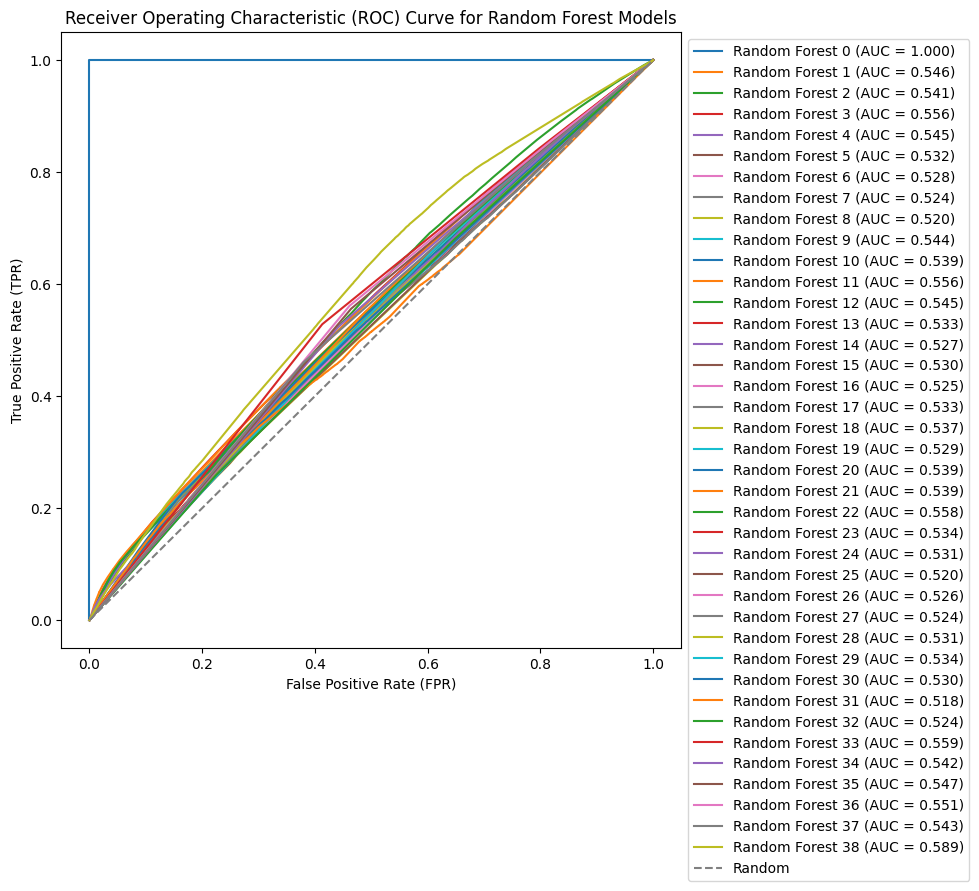

In [ ]:
plt.figure(figsize=(8, 8))

for (rfmodel_prob_scores, label) in prob_scores_rf:

    fpr_reg, tpr_reg, thresholds_reg = roc_curve(test_data[target], rfmodel_prob_scores)

    plt.plot(fpr_reg, tpr_reg, label=f"{label} (AUC = {roc_auc_score(test_data[target], rfmodel_prob_scores):.3f})")

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')


plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.title('Receiver Operating Characteristic (ROC) Curve for Random Forest Models')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')

# Show the plot with all ROC curves
plt.show()
